In [1]:
"""

Forecast SWnet response to cloudiness

"""

# Import modules
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4
from scipy import stats
import glob
import pathlib
import matplotlib.pyplot as plt

# Define path
path = '/Users/jryan4/Dropbox (University of Oregon)/research/clouds/data/'

In [2]:
# Define CMIP6 data
cmip_albedo_126 = sorted(glob.glob(path + 'cmip6-albedo/SSP126/*.nc'))
cmip_albedo_245 = sorted(glob.glob(path + 'cmip6-albedo/SSP245/*.nc'))
cmip_albedo_585 = sorted(glob.glob(path + 'cmip6-albedo/SSP585/*.nc'))

# Read MODIS climatologies
mod = netCDF4.Dataset(path + 'final_climatologies.nc')

# Read spreadsheet
data_current = pd.read_csv(path + 'cre_spreadsheet.csv')

# Define snowline
snowline_file = netCDF4.Dataset(path + 'sci-adv-products/Monthly_Bare_Ice_2012.nc')
snowline = snowline_file.variables['bare_ice'][1, :, :].filled(np.nan)
max_snowline = (snowline > 0.1)
mask = snowline_file.variables['mask'][:].astype('bool')
mask3d = np.repeat(max_snowline[:,:,np.newaxis], 86, axis=2)

In [3]:
mod

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Title: Net CRE, SW CRE, LW CRE, albedo and cloudiness from MODIS
    History: Created Mon Mar 28 15:24:27 2022
    Projection: WGS 84
    Reference: Ryan, J. C., Smith. L. C., Cooley, S. W., and Pearson, B. (in review), Emerging importance of clouds for Greenland Ice Sheet energy balance and meltwater production.
    Contact: jryan4@uoregon.edu
    dimensions(sizes): y(2881), x(1681), z(17)
    variables(dimensions): float32 latitude(y, x), float32 longitude(y, x), float32 cre(y, x, z), float32 cre_sw(y, x, z), float32 cre_lw(y, x, z), float32 albedo(y, x, z), float32 cloudiness(y, x, z), float32 allsky_sw(y, x, z), float32 allsky_lw(y, x, z), float32 clrsky_sw(y, x, z), float32 clrsky_lw(y, x, z)
    groups: 

In [4]:
""" First show albedo changes in the ablation zone under different scenarios"""

def cmip_mean_albedo(cmip_model):
    
    # Read first file
    cmip_a = xr.open_dataset(cmip_model)

    # Mask
    cmip_ablation = cmip_a['albedo'].where(mask3d == 1)

    # Average
    cmip_ablation_mean = np.nanmean(cmip_ablation, axis=(0,1))
    
    return cmip_ablation_mean

albedo_126 = []
for i in cmip_albedo_126:
    albedo_126.append(cmip_mean_albedo(i))

albedo_245 = []
for i in cmip_albedo_245:
    albedo_245.append(cmip_mean_albedo(i))
    
albedo_585 = []
for i in cmip_albedo_585:
    albedo_585.append(cmip_mean_albedo(i))

/var/folders/xj/5ps5mr8d5ysbd2mxxqjg3k800000gq/T/ipykernel_2480/742921532.py:12: RuntimeWarning: Mean of empty slice
  cmip_ablation_mean = np.nanmean(cmip_ablation, axis=(0,1))


In [5]:
# Find mean and range
cmip_126_iqr = np.nanpercentile(np.array(albedo_126), [75, 25], axis=0)
cmip_126_mean = np.nanmean(np.array(albedo_126), axis=0)

cmip_245_iqr = np.nanpercentile(np.array(albedo_245), [75, 25], axis=0)
cmip_245_mean = np.nanmean(np.array(albedo_245), axis=0)

cmip_585_iqr = np.nanpercentile(np.array(albedo_585), [75, 25], axis=0)
cmip_585_mean = np.nanmean(np.array(albedo_585), axis=0)

In [6]:
n_future = np.arange(2015, 2101, 1)
data_future = pd.DataFrame(list(zip(n_future, cmip_126_mean/100, cmip_126_iqr[0,:]/100, cmip_126_iqr[1,:]/100,
                                   cmip_245_mean/100, cmip_245_iqr[0,:]/100, cmip_245_iqr[1,:]/100,
                                   cmip_585_mean/100, cmip_585_iqr[0,:]/100, cmip_585_iqr[1,:]/100)), 
                           columns=['year', 'ssp126_mean', 'ssp126_higher', 'ssp126_lower',
                                   'ssp245_mean', 'ssp245_higher', 'ssp245_lower',
                                   'ssp585_mean', 'ssp585_higher', 'ssp585_lower'])

In [7]:
data_future['ssp585_mean']

0     0.665004
1     0.665585
2     0.660342
3     0.658996
4     0.653399
        ...   
81    0.520572
82    0.518760
83    0.522168
84    0.513902
85    0.513076
Name: ssp585_mean, Length: 86, dtype: float32

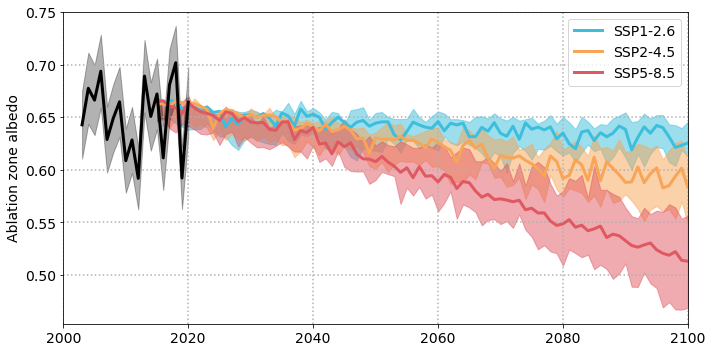

In [8]:
# Plot ablation zone albedo
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# Define colour map
c1 = '#E05861'
c3 = '#616E96'
c2 = '#F8A557'
c4 = '#3CBEDD'

ax1.plot(data_future['year'], data_future['ssp126_mean'], color=c4, lw=3, 
         zorder=2, label='SSP1-2.6')
ax1.fill_between(data_future['year'], data_future['ssp126_lower'], 
                 data_future['ssp126_higher'], color=c4, alpha=0.5)

ax1.plot(data_future['year'], data_future['ssp245_mean'], color=c2, lw=3, 
         zorder=2, label='SSP2-4.5')
ax1.fill_between(data_future['year'], data_future['ssp245_lower'], 
                 data_future['ssp245_higher'], color=c2, alpha=0.5)

ax1.plot(data_future['year'], data_future['ssp585_mean'], color=c1, lw=3, 
         zorder=2, label='SSP5-8.5')
ax1.fill_between(data_future['year'], data_future['ssp585_lower'], 
                 data_future['ssp585_higher'], color=c1, alpha=0.5)

ax1.plot(data_current['year'], data_current['alb_abl'], color='k', lw=3, zorder=2)
ax1.fill_between(data_current['year'],  data_current['alb_abl'] +  data_current['alb_abl']*0.05, 
                 data_current['alb_abl'] - data_current['alb_abl']*0.05, color='k', alpha=0.3)

ax1.grid(linestyle='dotted', lw=1.5, zorder=0)
ax1.set_ylabel('Ablation zone albedo', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(fontsize=14, loc=1)
ax1.set_xlim(2000, 2100)
fig.tight_layout()
fig.savefig('/Users/jryan4/Dropbox (University of Oregon)/research/clouds/revised-manuscript/supp_figures/fis_sx_future_albedo.png', dpi=200)

In [9]:
""" Second show relationship between cloudiness and SWnet in the ablation zone under different scenarios"""

def find_slopes(albedos):
    
    slopes = []
    for i in range(albedos.shape[0]):
        slope, inte, r, p, se = stats.linregress(data_current['cldy_abl']*100, data_current['allsky_sw_abl']* (1 - albedos.iloc[i]))
        slopes.append(slope)
    return np.abs(np.array(slopes))

In [10]:
data_current['slope_mean'] = find_slopes(data_current['alb_abl'])
data_future['ssp126_slope_mean'] = find_slopes(data_future['ssp126_mean'])
data_future['ssp126_slope_lower'] = find_slopes(data_future['ssp126_lower'])
data_future['ssp126_slope_higher'] = find_slopes(data_future['ssp126_higher'])
data_future['ssp245_slope_mean'] = find_slopes(data_future['ssp245_mean'])
data_future['ssp245_slope_lower'] = find_slopes(data_future['ssp245_lower'])
data_future['ssp245_slope_higher'] = find_slopes(data_future['ssp245_higher'])
data_future['ssp585_slope_mean'] = find_slopes(data_future['ssp585_mean'])
data_future['ssp585_slope_lower'] = find_slopes(data_future['ssp585_lower'])
data_future['ssp585_slope_higher'] = find_slopes(data_future['ssp585_higher'])

In [11]:
data_future.loc[:, data_future.columns != 'b']

,year,ssp126_mean,ssp126_higher,ssp126_lower,ssp245_mean,ssp245_higher,ssp245_lower,ssp585_mean,ssp585_higher,ssp585_lower,ssp126_slope_mean,ssp126_slope_lower,ssp126_slope_higher,ssp245_slope_mean,ssp245_slope_lower,ssp245_slope_higher,ssp585_slope_mean,ssp585_slope_lower,ssp585_slope_higher
0,2015,0.665460,0.664191,0.649109,0.662560,0.658921,0.645517,0.665004,0.669170,0.646479,1.331572,1.396656,1.336624,1.343117,1.410953,1.357602,1.333389,1.407125,1.316805
1,2016,0.663687,0.663458,0.648550,0.662773,0.658138,0.648156,0.665585,0.663155,0.649658,1.338630,1.398881,1.339544,1.342267,1.400449,1.360718,1.331074,1.394470,1.340748
2,2017,0.666362,0.662566,0.648773,0.660491,0.659612,0.640052,0.660342,0.661038,0.639191,1.327985,1.397993,1.343091,1.351353,1.432705,1.354849,1.351946,1.436133,1.349176
3,2018,0.664110,0.664142,0.644029,0.665150,0.661475,0.648820,0.658996,0.657858,0.635360,1.336947,1.416874,1.336822,1.332808,1.397805,1.347434,1.357304,1.451379,1.361830
4,2019,0.657986,0.657650,0.640973,0.664003,0.660557,0.650942,0.653399,0.664386,0.643286,1.361323,1.429038,1.362660,1.337374,1.389358,1.351089,1.379582,1.419832,1.335847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,2096,0.639992,0.652042,0.620346,0.582700,0.609880,0.560255,0.520572,0.559883,0.469104,1.432946,1.511141,1.384981,1.660982,1.750321,1.552800,1.908271,2.113133,1.751804
82,2097,0.631171,0.643089,0.607099,0.584999,0.618242,0.562508,0.518760,0.567317,0.474282,1.468054,1.563870,1.420616,1.651835,1.741356,1.519517,1.915486,2.092522,1.722214
83,2098,0.621221,0.642378,0.603776,0.593719,0.625512,0.553463,0.522168,0.564100,0.467182,1.507659,1.577096,1.423446,1.617125,1.777355,1.490578,1.901921,2.120784,1.735018
84,2099,0.623213,0.639572,0.618910,0.601580,0.627622,0.569613,0.513902,0.553580,0.467076,1.499730,1.516858,1.434617,1.585837,1.713074,1.482182,1.934821,2.121204,1.776892


In [12]:
1.96-1.55

0.4099999999999999

In [13]:
1.55-1.39

0.16000000000000014

In [14]:
0.41/0.16

2.5625

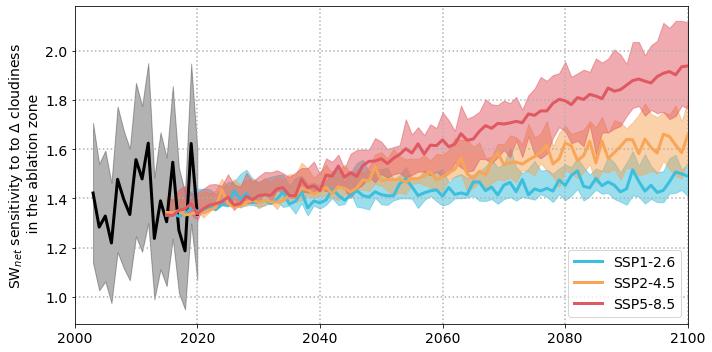

In [18]:
# Plot ablation zone SWnet sensitivity
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# Define colour map
c1 = '#E05861'
c3 = '#616E96'
c2 = '#F8A557'
c4 = '#3CBEDD'

ax1.plot(data_current['year'], data_current['slope_mean'], color='k', lw=3, zorder=2)
ax1.fill_between(data_current['year'],  data_current['slope_mean'] +  data_current['slope_mean']*0.2, 
                 data_current['slope_mean'] - data_current['slope_mean']*0.2, color='k', alpha=0.3)

ax1.plot(data_future['year'], data_future['ssp126_slope_mean'], color=c4, lw=3, 
         zorder=2, label='SSP1-2.6')
ax1.fill_between(data_future['year'], data_future['ssp126_slope_lower'], 
                 data_future['ssp126_slope_higher'], color=c4, alpha=0.5)

ax1.plot(data_future['year'], data_future['ssp245_slope_mean'], color=c2, lw=3, 
         zorder=2, label='SSP2-4.5')
ax1.fill_between(data_future['year'], data_future['ssp245_slope_lower'], 
                 data_future['ssp245_slope_higher'], color=c2, alpha=0.5)

ax1.plot(data_future['year'], data_future['ssp585_slope_mean'], color=c1, lw=3, 
         zorder=2, label='SSP5-8.5')
ax1.fill_between(data_future['year'], data_future['ssp585_slope_lower'], 
                 data_future['ssp585_slope_higher'], color=c1, alpha=0.5)

ax1.grid(linestyle='dotted', lw=1.5, zorder=0)
ax1.set_ylabel('SW$_{net}$ sensitivity to to $\Delta$ cloudiness \n in the ablation zone', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(fontsize=14, loc=4)
ax1.set_xlim(2000, 2100)
fig.tight_layout()
fig.savefig('/Users/jryan4/Dropbox (University of Oregon)/research/clouds/final-manuscript/figures/fig4_future_SWnet.pdf', dpi=200)

In [16]:
data_current['slope_mean'].mean()

1.390218217831312

In [24]:
data_future

,year,ssp126_mean,ssp126_higher,ssp126_lower,ssp245_mean,ssp245_higher,ssp245_lower,ssp585_mean,ssp585_higher,ssp585_lower,ssp126_slope_mean,ssp126_slope_lower,ssp126_slope_higher,ssp245_slope_mean,ssp245_slope_lower,ssp245_slope_higher,ssp585_slope_mean,ssp585_slope_lower,ssp585_slope_higher
0,2015,0.665460,0.664191,0.649109,0.662560,0.658921,0.645517,0.665004,0.669170,0.646479,1.331572,1.396656,1.336624,1.343117,1.410953,1.357602,1.333389,1.407125,1.316805
1,2016,0.663687,0.663458,0.648550,0.662773,0.658138,0.648156,0.665585,0.663155,0.649658,1.338630,1.398881,1.339544,1.342267,1.400449,1.360718,1.331074,1.394470,1.340748
2,2017,0.666362,0.662566,0.648773,0.660491,0.659612,0.640052,0.660342,0.661038,0.639191,1.327985,1.397993,1.343091,1.351353,1.432705,1.354849,1.351946,1.436133,1.349176
3,2018,0.664110,0.664142,0.644029,0.665150,0.661475,0.648820,0.658996,0.657858,0.635360,1.336947,1.416874,1.336822,1.332808,1.397805,1.347434,1.357304,1.451379,1.361830
4,2019,0.657986,0.657650,0.640973,0.664003,0.660557,0.650942,0.653399,0.664386,0.643286,1.361323,1.429038,1.362660,1.337374,1.389358,1.351089,1.379582,1.419832,1.335847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,2096,0.639992,0.652042,0.620346,0.582700,0.609880,0.560255,0.520572,0.559883,0.469104,1.432946,1.511141,1.384981,1.660982,1.750321,1.552800,1.908271,2.113133,1.751804
82,2097,0.631171,0.643089,0.607099,0.584999,0.618242,0.562508,0.518760,0.567317,0.474282,1.468054,1.563870,1.420616,1.651835,1.741356,1.519517,1.915486,2.092522,1.722214
83,2098,0.621221,0.642378,0.603776,0.593719,0.625512,0.553463,0.522168,0.564100,0.467182,1.507659,1.577096,1.423446,1.617125,1.777355,1.490578,1.901921,2.120784,1.735018
84,2099,0.623213,0.639572,0.618910,0.601580,0.627622,0.569613,0.513902,0.553580,0.467076,1.499730,1.516858,1.434617,1.585837,1.713074,1.482182,1.934821,2.121204,1.776892
